# Branch Creation for Parallel Node Execution

Việc thực thi song song các node là rất cần thiết để cải thiện hiệu suất tổng thể của các quy trình làm việc dựa trên đồ thị. LangGraph cung cấp hỗ trợ gốc cho việc thực thi song song các node, giúp tăng đáng kể hiệu quả của các quy trình làm việc được xây dựng bằng framework này.

Quá trình song song hóa này đạt được bằng cách sử dụng các cơ chế **fan-out** và **fan-in**, sử dụng cả các cạnh tiêu chuẩn (standard edges) và `conditional_edges`.

![branching-graph](../images/11-langgraph-branching-graph.png)

## Parallel Node Fan-out and Fan-in

**Fan-out / Fan-in**

Trong xử lý song song, **fan-out** và **fan-in** mô tả các quá trình phân chia và hợp nhất tác vụ.

-   **Fan-out (Mở rộng)**: Một tác vụ lớn được chia thành các tác vụ nhỏ hơn, dễ quản lý hơn. Ví dụ: khi làm pizza, bột, nước sốt và phô mai có thể được chuẩn bị độc lập. Việc chia các tác vụ để xử lý chúng đồng thời là fan-out.

-   **Fan-in (Hợp nhất)**: Các tác vụ nhỏ đã được chia được tập hợp lại để hoàn thành tác vụ tổng thể. Giống như việc lắp ráp các nguyên liệu đã chuẩn bị để tạo ra một chiếc pizza hoàn chỉnh, fan-in thu thập kết quả của các tác vụ song song để hoàn thiện quá trình.

Về bản chất, **fan-out** phân phối các tác vụ và **fan-in** thu thập kết quả để tạo ra đầu ra cuối cùng.

Ví dụ này minh họa một fan-out từ `Node A` đến `Node B` và `Node C`, tiếp theo là một fan-in đến `Node D`.

Trong **State**, toán tử `reducer(add)` được chỉ định. Điều này đảm bảo rằng thay vì chỉ đơn giản ghi đè các giá trị hiện có cho một khóa cụ thể trong State, các giá trị được kết hợp hoặc tích lũy. Đối với danh sách, điều này có nghĩa là nối danh sách mới vào danh sách hiện có.

LangGraph sử dụng kiểu `Annotated` để chỉ định các hàm reducer cho các khóa cụ thể trong State. Cách tiếp cận này cho phép gắn một hàm reducer (ví dụ: `add`) vào kiểu mà không thay đổi kiểu gốc (ví dụ: `list`) trong khi vẫn duy trì khả năng tương thích với kiểm tra kiểu.


In [3]:
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# Define State (using add_messages reducer)
class State(TypedDict):
    aggregate: Annotated[list, add_messages] # Tổng hợp
    
# Class for returning node values
class ReturnNodeValue:
    # Initialization
    def __init__(self, node_secret: str):
        self._value = node_secret

    # Updates the state when called
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}
    
# Initialize the state graph
builder = StateGraph(State)

# Create nodes A through D and assign values
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Connect the nodes
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

# Compile the graph
graph = builder.compile()

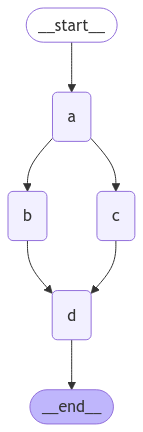

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the graph
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [5]:
# Execute the Graph
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='693377c5-f6af-40f1-9c6b-cd42f96bd80f')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='693377c5-f6af-40f1-9c6b-cd42f96bd80f')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='693377c5-f6af-40f1-9c6b-cd42f96bd80f'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='f2e25959-8add-4ab4-ac4b-eec4355bea01'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='3175d191-516d-4092-9fc0-3c68a36447e8')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='693377c5-f6af-40f1-9c6b-cd42f96bd80f'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='f2e25959-8add-4ab4-ac4b-eec4355bea01'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='3175d191-516d-4092-9fc0-3c68a36447e8'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='c1668d0f-695c-4910-80fa-0bcb06b037f6')]}

### Handling Exceptions during Parallel Processing

LangGraph thực thi các node trong một "superstep". Điều này có nghĩa là ngay cả khi các nhánh song song được thực thi đồng thời, toàn bộ superstep được xử lý theo kiểu **transactional**.

> **Superstep**: Một bước xử lý hoàn chỉnh liên quan đến nhiều node.

Do đó, nếu xảy ra ngoại lệ ở bất kỳ nhánh nào, **không có cập nhật nào** được áp dụng cho state (toàn bộ superstep được rollback).

![branching-graph](../images/11-langgraph-branching-graph.png)

Đối với các tác vụ dễ xảy ra lỗi (ví dụ: xử lý các lệnh gọi API không đáng tin cậy), LangGraph cung cấp hai giải pháp:

1.  Bạn có thể viết mã Python tiêu chuẩn trong các node để bắt và xử lý trực tiếp các ngoại lệ.
2.  Thiết lập **[retry\_policy](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.retry_policy)** để hướng dẫn graph thử lại các node gặp phải các loại ngoại lệ cụ thể. Chỉ các nhánh thất bại mới được thử lại, vì vậy bạn không cần lo lắng về việc xử lý lại không cần thiết.

Các tính năng này cho phép kiểm soát hoàn toàn việc thực thi song song và xử lý ngoại lệ.


## Fan-out and Fan-in of Parallel Nodes with Additional Steps

Ví dụ trước đã minh họa cách thực hiện `fan-out` và `fan-in` khi mỗi đường dẫn bao gồm một bước đơn lẻ. Nhưng điều gì xảy ra khi một đường dẫn chứa nhiều bước?


In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


# Define State (using add_messages reducer)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]


# Class for returning node values
class ReturnNodeValue:
    # Initialization
    def __init__(self, node_secret: str):
        self._value = node_secret

    # Updates the state when called
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# Initialize the state graph
builder = StateGraph(State)

# Create and connect nodes
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b1", ReturnNodeValue("I'm B1"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_edge("a", "b1")
builder.add_edge("a", "c")
builder.add_edge("b1", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

# Compile the graph
graph = builder.compile()

In [9]:
# from IPython.display import Image, display
# from langchain_core.runnables.graph import MermaidDrawMethod

# # Visualize the graph
# display(
#     Image(
#         graph.get_graph().draw_mermaid_png(
#             draw_method=MermaidDrawMethod.API,
#         )
#     )
# )

![](../images/c11.png)

In [10]:
# Execute Graph Aggregation with an Empty List, perform a basic aggregation operation across all data using an empty list as the initial state.
graph.invoke({"aggregate": []})

Adding I'm A to []
Adding I'm B1 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='baf73310-851f-4415-8b6f-c1e9a66501fe')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='baf73310-851f-4415-8b6f-c1e9a66501fe')]
Adding I'm B2 to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='baf73310-851f-4415-8b6f-c1e9a66501fe'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='eeb4fa4a-5067-4fea-9474-8ca331d28d23'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='aa9f7ff8-d4da-46df-bfa3-ff738c1ebee1')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='baf73310-851f-4415-8b6f-c1e9a66501fe'), HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='eeb4fa4a-5067-4fea-9474-8ca331d28d23'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='aa9f7

{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='baf73310-851f-4415-8b6f-c1e9a66501fe'),
  HumanMessage(content="I'm B1", additional_kwargs={}, response_metadata={}, id='eeb4fa4a-5067-4fea-9474-8ca331d28d23'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='aa9f7ff8-d4da-46df-bfa3-ff738c1ebee1'),
  HumanMessage(content="I'm B2", additional_kwargs={}, response_metadata={}, id='6cf101db-8b8c-4fd7-89ca-8c07edd6d0d3'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='592c2f02-ff5f-45c3-b0bd-5fd7565a8478')]}

## Conditional Branching

When the fan-out is non-deterministic, you can directly use `add_conditional_edges`.

In [11]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages


# Define State (using add_messages reducer)
class State(TypedDict):
    aggregate: Annotated[list, add_messages]
    which: str


# Class for returning unique values per node
class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


# Initialize the state graph
builder = StateGraph(State)

# Define nodes and connect them
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


# Define the routing logic based on the 'which' value in the state
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# List of nodes to process in parallel
intermediates = ["b", "c", "d"]

builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
)

for node in intermediates:
    builder.add_edge(node, "e")


# Connect the final node and compile the graph
builder.add_edge("e", END)
graph = builder.compile()

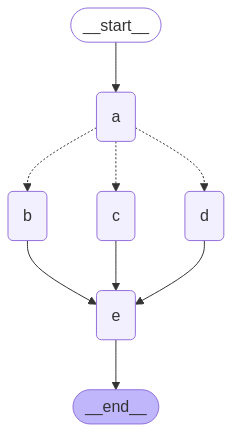

In [13]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Visualize the graph
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Nếu có một node "sink" đã biết để kết nối sau phân nhánh điều kiện, bạn có thể chỉ định `then="node_name_to_execute"` khi tạo cạnh điều kiện.

Dưới đây là một đoạn mã tham khảo. Khi sử dụng cú pháp `then`, bạn có thể thêm `then="e"` và bỏ qua việc thêm kết nối cạnh rõ ràng.



In [ ]:
## Using the `then` Syntax
# builder.add_conditional_edges(
#     "a",
#     route_bc_or_cd,
#     intermediates,
#     then="e",
# )

In [14]:
# Execute the Graph (set `which`:`bc`)
graph.invoke({"aggregate": [], "which": "bc"})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e6de8988-d933-4f14-ba0e-fae840be4076')]
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e6de8988-d933-4f14-ba0e-fae840be4076')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e6de8988-d933-4f14-ba0e-fae840be4076'), HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='a1d38404-e819-49cb-83d5-a849d59ee720'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='2044e948-b3db-4cd7-8a84-1176225597ce')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='e6de8988-d933-4f14-ba0e-fae840be4076'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='a1d38404-e819-49cb-83d5-a849d59ee720'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='2044e948-b3db-4cd7-8a84-1176225597ce'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='bd927e33-2c8c-4a88-a9c7-4cd6246b45f1')],
 'which': 'bc'}

In [15]:
# Execute the Graph (set `which`:`cd`)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='8232e95c-3fc1-4c41-8bc6-617a23899dbf')]
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='8232e95c-3fc1-4c41-8bc6-617a23899dbf')]
Adding I'm E to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='8232e95c-3fc1-4c41-8bc6-617a23899dbf'), HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='8990d131-9d54-46c3-b259-a152bb31a8fe'), HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='3d87294a-9628-4a95-80a9-3624a1352a4a')]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='8232e95c-3fc1-4c41-8bc6-617a23899dbf'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='8990d131-9d54-46c3-b259-a152bb31a8fe'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='3d87294a-9628-4a95-80a9-3624a1352a4a'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='ce626cb9-de11-438e-881a-f83f6a79977c')],
 'which': 'cd'}

## Sorting Based on Reliability of Fan-out Values

Các node được phân tán song song được thực thi như một phần của một "**super-step**" duy nhất. Các cập nhật từ mỗi super-step chỉ được áp dụng tuần tự cho state sau khi super-step hoàn thành.

Nếu cần một thứ tự cập nhật nhất quán, được xác định trước trong một super-step song song, các giá trị đầu ra có thể được ghi lại trong một trường riêng biệt của state với một khóa nhận dạng. Sau đó, sử dụng các `edges` tiêu chuẩn từ mỗi node fan-out đến điểm hội tụ, nơi một node "sink" kết hợp các đầu ra này.

Ví dụ: hãy xem xét một tình huống mà bạn muốn sắp xếp đầu ra của các bước song song dựa trên "độ tin cậy" của chúng.


In [16]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# Logic to merge fan-out values, handle empty lists, and concatenate lists
def reduce_fanouts(left, right):
    if left is None:
        left = []
    if not right:
        # Overwrite
        return []
    return left + right


# Type definition for state management, configuring structures for aggregation and fan-out values
class State(TypedDict):
    # Use the add_messages reducer
    aggregate: Annotated[list, add_messages]
    fanout_values: Annotated[list, reduce_fanouts]
    which: str


# Initialize the graph
builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")


# Class for returning parallel node values
class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    # Update the state when called
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }


# Add parallel nodes with different reliability values
builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.1))
builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.9))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.5))


# Aggregate fan-out values based on reliability and perform final aggregation
def aggregate_fanout_values(state: State) -> Any:
    # Sort by reliability
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    print(ranked_values)
    return {
        "aggregate": [x["value"][0] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }


# Add aggregation node
builder.add_node("e", aggregate_fanout_values)


# Define conditional routing logic based on state
def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


# Configure intermediate nodes and add conditional edges
intermediates = ["b", "c", "d"]
builder.add_conditional_edges("a", route_bc_or_cd, intermediates)

# Connect intermediate nodes to the final aggregation node
for node in intermediates:
    builder.add_edge(node, "e")

# Finalize the graph
graph = builder.compile()

In [20]:
# from IPython.display import Image, display
# display(Image(graph.get_graph().draw_mermaid_png()))

![](../images/c11_2.png)

The results from executing nodes in parallel are then sorted based on their reliability.

**Reference**

- `b`: reliability = 0.1  
- `c`: reliability = 0.9  
- `d`: reliability = 0.5

In [21]:
# Execute the Graph (set `which`:`bc`)
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})

Adding I'm A to []
Adding I'm B to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='91593284-048d-4a68-897b-5bcd68a53fa8')] in parallel.
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='91593284-048d-4a68-897b-5bcd68a53fa8')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm B"], 'reliability': 0.1}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='91593284-048d-4a68-897b-5bcd68a53fa8'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='d0de38a3-1caf-43ca-9363-fc835813b0ca'),
  HumanMessage(content="I'm B", additional_kwargs={}, response_metadata={}, id='2995eb83-6d1f-4e26-8e42-35d23e41aba6'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='e1d12a75-7d6e-4ada-83cf-fdf427aa3199')],
 'fanout_values': [],
 'which': 'bc'}

In [22]:
# Execute the Graph (set `which`:`cd`)
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='4fe0ee50-bc50-4d3e-bb39-3c90611181b7')] in parallel.
Adding I'm D to [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='4fe0ee50-bc50-4d3e-bb39-3c90611181b7')] in parallel.
[{'value': ["I'm C"], 'reliability': 0.9}, {'value': ["I'm D"], 'reliability': 0.5}]


{'aggregate': [HumanMessage(content="I'm A", additional_kwargs={}, response_metadata={}, id='4fe0ee50-bc50-4d3e-bb39-3c90611181b7'),
  HumanMessage(content="I'm C", additional_kwargs={}, response_metadata={}, id='39791792-debd-4cd5-b695-2bb4f733a41c'),
  HumanMessage(content="I'm D", additional_kwargs={}, response_metadata={}, id='88c3d847-f7f2-47e5-a906-7863c85de230'),
  HumanMessage(content="I'm E", additional_kwargs={}, response_metadata={}, id='c191c77e-d0ca-4223-bb3f-4d2d2d3d7e21')],
 'fanout_values': [],
 'which': 'cd'}